In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.makedirs('Figure_5', exist_ok=True)


# Figure 5
### Disruption of cortical development in preterm-born infants
Make sure results from `A__principal_components.py` and `F__windowed_correlations.py` are available

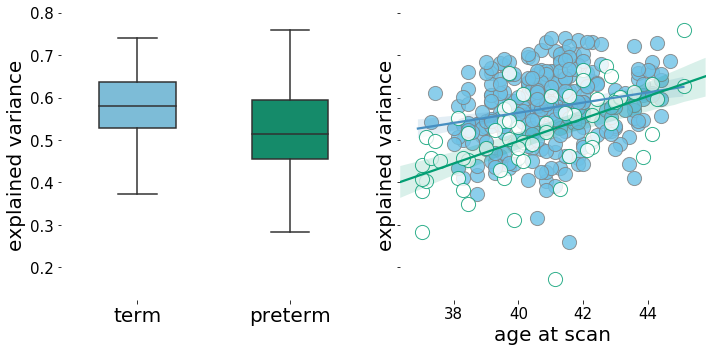

In [11]:
## PCA variance explained per subject: term vs preterm
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(10,5), sharey=True)
group_palette=['#6ec2e6','#029e73']

# load data
region_average_all_xy = pd.read_csv('../results/PCA/principal-components-explained-variance-per-subject.csv')

# BOXPLOT
sns.boxplot(x="group", y="EV1", data=region_average_all_xy, fliersize=0,
            width=0.5,palette=group_palette, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('explained variance', fontsize=20)

# REGRESSIONS
sns.regplot('age_at_scan', 'EV1', data=region_average_all_xy.loc[region_average_all_xy['group']=='term'], ax=ax2,
           color=group_palette[0],scatter_kws={'s':200,'edgecolor':"grey"}, line_kws={'color':'#478fc1'})

sns.regplot('age_at_scan', 'EV1', data=region_average_all_xy.loc[region_average_all_xy['group']=='preterm'], ax=ax2,
           color='w', line_kws={'color':group_palette[1]},scatter_kws={'s':200,'edgecolor':group_palette[1]})
ax2.set_ylabel('explained variance', fontsize=20)
ax2.set_xlabel('age at scan', fontsize=20)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=20)
sns.despine(left=True, bottom=True)

# SAVEOUT
plt.tight_layout()
plt.savefig('Figure_5/Figure_5A.png')

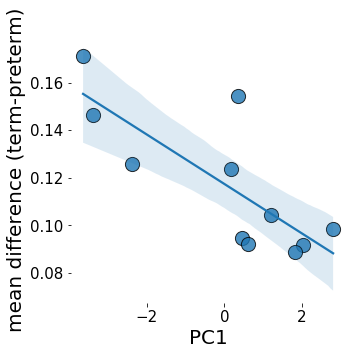

In [12]:
fig, ax3 =plt.subplots(1,1, figsize=(5,5), sharey=True)
metric = 'myelin'

# load data
out_data = pd.read_csv('../data/processed_imaging/term-vs-preterm-cortical-metrics-corrected-for-age-and-sex.csv')

# set up
plot_data = out_data.loc[out_data['metric']==metric,:].copy()
group_dict={0:'preterm',1:'term'}
plot_data['group'] = plot_data['term'].map(group_dict).copy()

# relationship between PC1 and mean group differences in metrics
group_differences =  pd.DataFrame((plot_data[plot_data['term']==1].groupby(['region','metric']).mean()['value'] - plot_data[plot_data['term']==0].groupby(['region','metric']).mean()['value']))
group_differences.reset_index(inplace=True)

# PCA data
pca_data = pd.read_csv('../results/PCA/mean-regional-principal-components.csv')
pca_dict = dict(zip(pca_data['region'], pca_data['PC1']))
group_differences['PC1'] = group_differences['region'].map(pca_dict)

# REGRESSION PLOT
sns.regplot('PC1', 'value', data=group_differences, truncate=True, ax=ax3, scatter_kws={'s':200, 'edgecolor':'black'})

ax3.set_ylabel('mean difference (term-preterm)', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.set_xlabel('PC1', fontsize=20)

sns.despine(left=True, bottom=True)

# save
plt.tight_layout()
plt.savefig('Figure_5/Figure_5B.png')

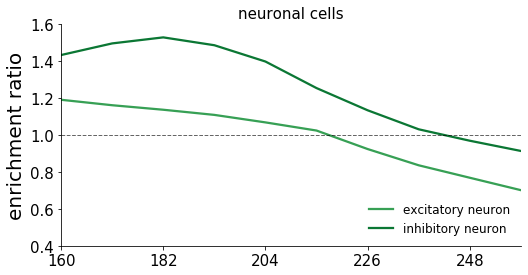

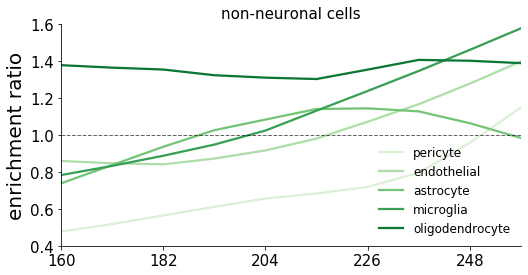

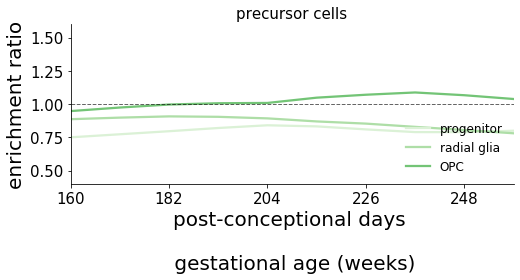

In [14]:
# WINDOWED ENRICHMENT PLOTS
# load data
windowed_enrichment = pd.read_csv('../results/enrichment/windowed-enrichment.csv')
windowed_enrichment = windowed_enrichment.loc[:,['_p' not in p for p in windowed_enrichment.columns]]
plot_enrichment = windowed_enrichment.melt(id_vars='age window')
plot_enrichment.columns = ['window', 'cell class', 'enrichment']

better_names = {'neuron_inhibitory':'inhibitory neuron', 'neuron_excitatory':'excitatory neuron', 'radial_glia': 'radial glia'}
plot_enrichment['cell class'] = plot_enrichment['cell class'].map(better_names).fillna(plot_enrichment['cell class'])

mean_enrichment = plot_enrichment.groupby('cell class').mean().reset_index()

cell_class_dict = {'pericyte':'non-neuronal',
                   'progenitor':'precursor',
                   'radial glia':'precursor',
                   'excitatory neuron':'neuronal',
                   'OPC':'precursor',
                   'endothelial':'non-neuronal',
                   'astrocyte':'non-neuronal',
                   'microglia':'non-neuronal',
                   'inhibitory neuron':'neuronal',
                   'oligodendrocyte':'non-neuronal'}

plot_enrichment['cell type'] = plot_enrichment['cell class'].map(cell_class_dict)

colors = sns.color_palette('Greens', n_colors=5)
# neuronal cells
ct = 'neuronal'
order=plot_enrichment[plot_enrichment['cell type']==ct].groupby('cell class').mean().reset_index().sort_values(by='enrichment')['cell class'].values
# plot
g = sns.lmplot('window', 'enrichment', hue='cell class', data=plot_enrichment[plot_enrichment['cell type']==ct],
           palette=colors[-2:], col='cell type', hue_order=order,legend=False,
           lowess=True, scatter=False, height=4, aspect=1.8)
# format
plt.title('neuronal cells', fontsize=15)
plt.ylim(0.4, 1.6)
plt.axhline(y=1, lw=1, linestyle='--', c='black', alpha=0.6)
g.ax.tick_params(axis='both', which='major', labelsize=15)

# non-neuronal cells
ct = 'non-neuronal'
order=plot_enrichment[plot_enrichment['cell type']==ct].groupby('cell class').mean().reset_index().sort_values(by='enrichment')['cell class'].values
# plot
h = sns.lmplot('window', 'enrichment', hue='cell class', data=plot_enrichment[plot_enrichment['cell type']==ct],
           palette=colors, col='cell type', hue_order=order,legend=False,
           lowess=True, scatter=False, height=4, aspect=1.8)
# format
plt.title('non-neuronal cells', fontsize=15)
plt.ylim(0.4, 1.6)
plt.axhline(y=1, lw=1, linestyle='--', c='black', alpha=0.6)
h.ax.tick_params(axis='both', which='major', labelsize=15)

# precursor cells
ct = 'precursor'
order=plot_enrichment[plot_enrichment['cell type']==ct].groupby('cell class').mean().reset_index().sort_values(by='enrichment')['cell class'].values
# plot
j = sns.lmplot('window', 'enrichment', hue='cell class', data=plot_enrichment[plot_enrichment['cell type']==ct],
           palette=colors[:3], col='cell type', hue_order=order,
           lowess=True, scatter=False, height=4, aspect=1.8, legend=False)
# format
plt.title('precursor cells', fontsize=15)
plt.ylim(0.4, 1.6)
plt.axhline(y=1, lw=1, linestyle='--', c='black', alpha=0.6)
plt.tight_layout()
for plot in g, h, j:
    plot.ax.tick_params(axis='both', which='major', labelsize=15)
    plot.ax.set_xticks([0,2,4,6,8])
    plot.ax.set_xticklabels(np.linspace(160, 260, 10).astype(int)[[0,2,4,6,8]])
    plot.ax.set_xlim(0,9)
    plot.ax.set_xlabel('', fontsize=20)
    plot.ax.set_ylabel('enrichment ratio', fontsize=20)
    plot.ax.legend(fontsize='large', title_fontsize='90', loc='lower right', framealpha=0)
j.ax.set_xlabel('post-conceptional days \n \n gestational age (weeks)', fontsize=20)

plt.tight_layout()
plt.savefig('Figure_5/Figure_5C.png')